# Kangaroo detection using a Mask-RCNN Model

## First we need to clone the Mask-RCNN project from github

In [6]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 32.88 MiB/s, done.
Resolving deltas: 100% (562/562), done.


## Then we need to import all the libraries that we are going to use

With the versions that Mask-RCNN requires:

tensorflow==1.15.3

keras==2.2.4

In [27]:
import os
%tensorflow_version 1.15.3
import tensorflow as tf
from mrcnn.utils import Dataset
from google.colab import drive
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from os import listdir
import keras_applications
from numpy import zeros
from numpy import asarray
from matplotlib import pyplot
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib.patches import Rectangle

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.3`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [8]:
!pip install q keras==2.2.4
os.chdir('Mask_RCNN')

## Now we need to get the information of each image saved on a xml file

(For instance we will get this info for the image 'kangaroo-34')

In [9]:
drive.mount('/content/gdrive')
ruta = '/content/gdrive/MyDrive/Colab Notebooks'

tree = ET.parse(ruta + '/Proyecto/annotations/kangaroo-34.xml')

# The root variable allows to access to the xml info with indexes
root = tree.getroot()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- And here we extract the info contained on the tree obj

In [10]:
img_name = root.find('filename').text
image_width = int(root.find('.//size/width').text)
image_height = int(root.find('.//size/height').text)
bounds = []
for info in root.findall('.//bndbox'):
    x_min = int(info.find('xmin').text)
    y_min = int(info.find('ymin').text)
    x_max = int(info.find('xmax').text)
    y_max = int(info.find('ymax').text)
    bound = [x_min, x_max, y_min, y_max]
    bounds.append(bound)
print('img_name-> ', img_name)
print('image_width-> ', image_width)
print('image_height-> ', image_height)
print('bounds-> ', bounds)
print(len(bounds))

img_name->  kangaroo-34.jpg
image_width->  1200
image_height->  800
bounds->  [[1081, 1198, 318, 645], [984, 1088, 302, 630], [840, 1108, 318, 700], [658, 766, 371, 713], [451, 602, 339, 671], [532, 638, 285, 630], [333, 439, 412, 696], [165, 283, 307, 490], [276, 366, 352, 549]]
9


- After that we create a method that provides this info (that we will use later to get this info from all the images)

In [11]:
def get_image_data(image):
    tree_f = ET.parse(ruta + '/Proyecto/annotations/'+ image)
    root_f = tree_f.getroot()
    img_name = root_f.find('filename').text
    image_width = int(root_f.find('.//size/width').text)
    image_height = int(root_f.find('.//size/height').text)
    bounds = []

    for info in root_f.findall('.//bndbox'):
        x_min = int(info.find('xmin').text)
        y_min = int(info.find('ymin').text)
        x_max = int(info.find('xmax').text)
        y_max = int(info.find('ymax').text)
        bound = [x_min, x_max, y_min, y_max]
        bounds.append(bound)
    return(img_name, image_width,image_height, bounds)

In [13]:
print(get_image_data('kangaroo-4.xml'))

('kangaroo-4.jpg', 862, 647, [[286, 795, 81, 503]])


## kangaroo dataset class

- This class will be used to get all the data required to train the kangaroo dataset.
- Additional to the methods overwritten on this class we created this two:

      is_file_contained_in_the_list
      get_training_and_test_separate_lists

  In order to separate the training and validation data randomly and save it in the kangaroo class

In [14]:
class KangarooDataset(Dataset):

    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train = True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        # separate the test and train data
        list_train, list_test = self.get_training_and_test_separate_lists()
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip test images for train
            if not is_train and self.is_file_contained_in_the_list(filename, list_train):
                continue
            # skip train images for test
            if is_train and self.is_file_contained_in_the_list(filename, list_test):
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    def get_image_data(self, path):
        tree_f = ET.parse(path)
        root_f = tree_f.getroot()
        img_name = root_f.find('filename').text
        image_width = int(root_f.find('.//size/width').text)
        image_height = int(root_f.find('.//size/height').text)
        bounds = []

        for info in root_f.findall('.//bndbox'):
            x_min = int(info.find('xmin').text)
            y_min = int(info.find('ymin').text)
            x_max = int(info.find('xmax').text)
            y_max = int(info.find('ymax').text)
            bound = [x_min, x_max, y_min, y_max]
            bounds.append(bound)
        return(bounds, image_width, image_height)
    
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.get_image_data(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)])
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            y_min, y_max = box[2], box[3]
            x_min, x_max = box[0], box[1]
            masks[y_min:y_max, x_min:x_max, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    def get_training_and_test_separate_lists(self):
        list_dir = listdir(ruta + '/Proyecto/images')
        # these will be the input_lists:
        list_test_r = random.sample(list_dir, int(len(list_dir)*.2))
        list_train_r = []
        for name in list_dir:
            flag = True
            for test in list_test_r:
                if name == test:
                    flag = False
            if flag:
                list_train_r.append(name)

        return list_train_r, list_test_r
    
    def is_file_contained_in_the_list(self, file, input_list):
        is_present = False
        for element in input_list:
            if file == element:
                is_present = True
        return is_present

## Now we prepare the train and test set of data to be ready for the training

As you can notice we decide to split the data 80% (251 images) for training and 20% (62 images) for test 

In [17]:
path = ruta + '/Proyecto'
# train set
train_set = KangarooDataset()
train_set.load_dataset(path, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = KangarooDataset()
test_set.load_dataset(path, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 251
Test: 62


- In here we can see the boxes correctly created for segmentation of a random image from the test data set

{'id': 'kangaroo-290', 'source': 'dataset', 'path': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/images/kangaroo-290.jpg', 'annotation': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/annotations/kangaroo-290.xml'}
(930, 1396, 3)
class_ids ->  [1]
1


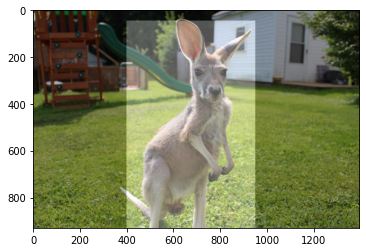

In [57]:
# load an image
image_id = 16
print(test_set.image_info[image_id])
image = test_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = test_set.load_mask(image_id)
print('class_ids -> ', class_ids)
print(mask.shape[2])
# plot image
pyplot.imshow(image)
# plot masks
for i in range(mask.shape[2]):
    pyplot.imshow(mask[:, :, i], cmap='gray', alpha=0.3)

pyplot.show()

- Same as above but for the train data set

{'id': 'kangaroo-635', 'source': 'dataset', 'path': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/images/kangaroo-635.jpg', 'annotation': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/annotations/kangaroo-635.xml'}
(1333, 2000, 3)
class_ids ->  [1 1]
2


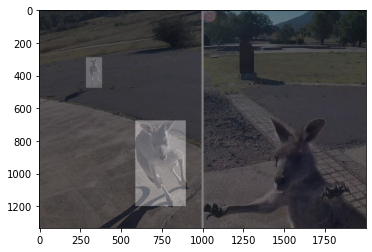

In [74]:
# load an image
image_id = 215
print(train_set.image_info[image_id])
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print('class_ids -> ', class_ids)
print(mask.shape[2])
# plot image
pyplot.imshow(image)
# plot masks
for i in range(mask.shape[2]):
    pyplot.imshow(mask[:, :, i], cmap='gray', alpha=0.3)

pyplot.show()

## Now we create a small class to define the configuration for the training

In [19]:
# define a configuration for the model
class KangarooConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)

Note: It is recomended to set the ammount of photos in the training dataset as the 'STEPS_PER_EPOCH' param to get good results.

- And we use this object to set the config param to save the model

In [20]:
config = KangarooConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', config=config, model_dir=path + '/')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

- Now in order to improve the performance results of the model we load to the model the weights of a pre-trained mask neuronal networ called 'mask_rcnn_coco'

Note: Is important to know that we will use all the 'coco model' weights but the class-specific output layers will be 'exclude' so that new output layers can be defined and trained by our own data.

In [21]:
model.load_weights(path + '/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

## Now we are ready to train our model with the data that we already prepare

In [22]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/MyDrive/Colab Notebooks/Proyecto/kangaroo_cfg20210521T1631/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4 

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
251/251 [==============================] - 299s 1s/step - loss: 0.9566 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2591 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.2796 - val_loss: 0.6980 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.2764 - val_mrcnn_class_loss: 0.0414 - val_mrcnn_bbox_loss: 0.1693 - val_mrcnn_mask_loss: 0.2058

Epoch 2/10
251/251 [==============================] - 249s 991ms/step - loss: 0.6284 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2032 - val_loss: 0.6538 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.2469 - val_mrcnn_class_loss: 0.0234 - val_mrcnn_bbox_loss: 0.1724 - val_mrcnn_mask_loss: 0.2062
Epoch 3/10
251/251 [==============================] - 248s 990ms/step - loss: 0.5249 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1884 - val_loss: 0.5765 - val_rp

- Now that we have our model trained, we can test it in new images!!

# Test model in new images

- In order to make this tests we created a method that will extract the bounding boxes detected for the input image and plot this as a red box that will select the kangaroos.

Note: As the training set of images is small in comparison with the amount of data used to train the 'coco model' that we used also to train our model. It will identify different objects (not only kangaroos) so to get better results we identify that an score higher than 0.97 is a good standar to visualize rounded in the red box the kangaroos only (Although it keeps identifiying somme other animals with simmilar morphological shape as kangaroos)

- And we create also a small class to set the test configuration

In [76]:
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list, scores):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for i in range(len(boxes_list)):
      if scores[i] > 0.968:
        # get coordinates
        y1, x1, y2, x2 = boxes_list[i]
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "kangaroo"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 1

- After that we define the model that we are going to use for the testing and we load to this model the kangaroo model weights generated previously

In [77]:
# define the model
rcnn = MaskRCNN(mode='inference', model_dir= path + '/', config=TestConfig())
# load kangaroo model weights
rcnn.load_weights(path + '/kangaroo_cfg20210517T2151/mask_rcnn_kangaroo_cfg_0010.h5', by_name=True)

Re-starting from epoch 10


- Finally we are able to test any image with our brand new model

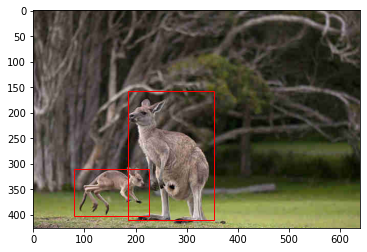

[0.99880946 0.99501204 0.9372356 ]
[1 1 1]


In [85]:
image = path + '/test_images/06.jpg'
img = load_img(image)
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)[0]
# visualize the results
draw_image_with_boxes(image, results['rois'], results['scores'])
print(results['scores'])
print(results['class_ids'])

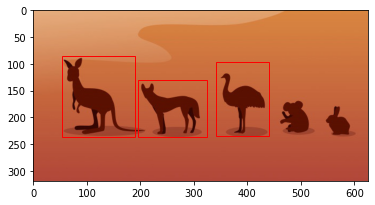

[0.99624485 0.9953655  0.9800944  0.95521224 0.886483  ]
[1 1 1 1 1]


In [79]:
image = path + '/test_images/animals4.jpg'
img = load_img(image)
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)[0]
# visualize the results
draw_image_with_boxes(image, results['rois'], results['scores'])
print(results['scores'])
print(results['class_ids'])

## Model Architecture

In [ ]:
model = rcnn.load_weights(path + '/kangaroo_cfg20210517T2151/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)

Re-starting from epoch 5


In [ ]:
rcnn.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(rcnn.keras_model, to_file= path + '/model.png',
          show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.792392 to fit



## Mask R-CNN draws epoch-loss curve

In [32]:
file_path = path + "/loss_results_f.csv"
data = pd.read_csv(file_path)

In [33]:
data

epoch    loss  ...  val_mrcnn_bbox_loss  val_mrcnn_mask_loss
0      1  0.9566  ...               0.1693               0.2058
1      2  0.6284  ...               0.1724               0.2062
2      3  0.5249  ...               0.1325               0.2013
3      4  0.4575  ...               0.1078               0.1852
4      5  0.3926  ...               0.0808               0.1656
5      6  0.3619  ...               0.0851               0.1573
6      7  0.3627  ...               0.0764               0.1573
7      8  0.3339  ...               0.0838               0.1591
8      9  0.2895  ...               0.0721               0.1694
9     10  0.2514  ...               0.0383               0.1276

[10 rows x 13 columns]

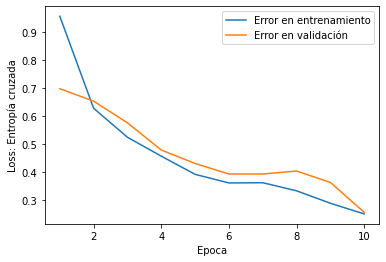

In [35]:
plt.figure()
plt.xlabel('Epoca')
plt.ylabel('Loss: Entropía cruzada')
plt.plot(data['epoch'], data['loss'],
           label='Error en entrenamiento')
plt.plot(data['epoch'], data['val_loss'],
           label='Error en validación')
plt.legend()
plt.show()

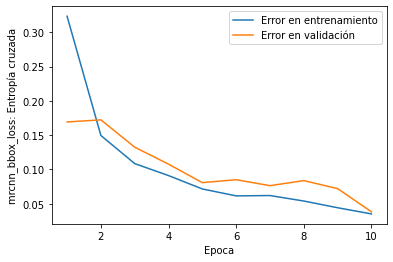

In [36]:
plt.figure()
plt.xlabel('Epoca')
plt.ylabel('mrcnn_bbox_loss: Entropía cruzada')
plt.plot(data['epoch'], data['mrcnn_bbox_loss'],
           label='Error en entrenamiento')
plt.plot(data['epoch'], data['val_mrcnn_bbox_loss'],
           label='Error en validación')
plt.legend()
plt.show()

## We can also calculate the Mean Average Presition of our model with the test and train data set

In [86]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [101]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from numpy import mean

def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [102]:
# evaluate model on training dataset
cfg = PredictionConfig()
train_mAP = evaluate_model(train_set, rcnn, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, rcnn, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.961
Test mAP: 0.924


# References

- https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/ 

- https://github.com/AprendizajeProfundo/Diplomado/blob/master/

- https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/
